In [ ]:
# # 02.2024 WKJEE
# Q1 PF (ParameterFinder) Tests
# IRLS added
#
# Penalty added to keep the param functions in a desired shape
# possible other scenarios worth to check
#
# (1) No IRLS (only gradient based Basin-Hopping)
# (2) ...
#

import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data loading and Generation
# -------------------------

# Conditions used for model evaluation

exp_clist = np.array([0.37, 0.36, 0.46, 0.39])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56])
Templist  = np.array([298, 298, 298, 298])
Cratelist = np.array([0.5, 0.5, 0.8, 0.8])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0])
#
# well found case : current Q1 expression cannot describe Q3 (accel. deg) -> paramter finding ends with somehow averaged gnorm result.
#
exp_clist = np.array([0.37, 0.36, 0.46])
exp_zlist = np.array([0.49, 0.50, 0.50])
Templist  = np.array([298, 298, 298])
Cratelist = np.array([0.5, 0.5, 0.8])
Dratelist = np.array([0.5, 1.0, 2.0])

# Conditions used for model evaluation
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])
Templist  = np.array([298, 298, 298, 298, 298, 298])
Cratelist = np.array([0.53, 0.5, 0.8, 0.8, 1.0, 1.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

# Maximum cycles for each dataset (order: dataset with fastest Q growth last)
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
#exp_maxcyclelist = np.array([3300, 3000, 2000, 1300])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride),
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]


# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""

    h, DT, a = params
    #return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)
    return h + np.abs(DT) * np.power(1. - np.exp( np.abs(a) * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [AC, RhoC]"""
    #A, Rho = params
    #return A * np.exp(Crate / Rho)
    ca, A, cb, Rho = params
    return ca * np.power(A,Crate) + cb * np.exp(Crate/Rho)

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [AD, RhoD]"""
    #A, Rho = params
    #return A * np.exp(Crate / Rho)
    ca, A, cb, Rho = params
    return ca * np.power(A,Crate) + cb * np.exp(Crate/Rho)

def Q1loss(params, condition, cyc):
    """
    Combined model output.
    params: [h, DT, a, AC, RhoC, AD, RhoD, B0]
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    """
    T_params = params[0:3]
    Ch_params = params[3:7]
    Dch_params = params[7:11]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    return (B0 * Q1Temp(T_params, Temp) * 
            Q1DchCrate(Ch_params, ChCrate) * Q1DchCrate(Dch_params, DchCrate) * 
            np.exp(-_Ea / (Temp * _R)) *
            np.power(cyc, _n))
#
# Need to define : Q3Crate
#

def Q3Crate( params, Crate ):
    """
    Swish-like trial function
    """
    #a, b, c, d = params
    #return a*(Crate - b) / (1 + np.exp( -np.abs(c) * (Crate - d))
    a, b, c = params
    return a*(Crate - b) / (1 + np.exp( -np.abs(c) * (Crate - b)))

def Q3loss(params, condition, cyc):
    """
    Combined Q3 model output.
    params: [
    condition: [Temp, ChCrate, DchCrate, ]
    cyc: cycle number(s)
    """
    Tm0_params = params[0:3]
    Chm0_params = params[3:7]
    Dhm0_params = params[7:11]
    TFcm_params = params[11:14]
    ChFcm_params = params[14:18]
    DchFcm_params = params[18:22]

    Temp, ChCrate, DchCrate = condition
    return 0.00000001 * \
    np.exp( -(Q1Temp(Tm0_params, Temp) + Q1DchCrate(Chm0_params, ChCrate) + Q1DchCrate(Dhm0_params, DchCrate)) ) * \
    ( np.exp( Q1Temp(TFcm_params, Temp) * Q1DchCrate( ChFcm_params, ChCrate ) * Q1DchCrate( DchFcm_params, DchCrate ) * cyc ) - 1 )

def Q13loss( params, condition, cyc ):
    Q1params = params[:12]
    Q3params = params[12:]
    return Q1loss( Q1params, condition, cyc ) + Q3loss( Q3params, condition, cyc )

#
# * * * Q3 Initial Guess * * *
# 3 4 4 3 4 4 : total 22 parameters

Tm0_initial_guess  = [ 1, 0.3, 0.5 ]
Chm0_initial_guess = [ 2, 1, 2, 16 ]
Dchm0_initial_guess = [ 0.5, 4, 0.2, 24 ]

TFcm_initial_guess = [ 0.13, 0.5, 0.043 ]
ChFcm_initial_guess = [ 2, 1, 2, 16 ]
DchFcm_initial_guess = [ 0.5, 4, 0.2, 24 ]

# Q3 Intial Guess
Q3_initial_guess = Tm0_initial_guess + Chm0_initial_guess + Dchm0_initial_guess + TFcm_initial_guess \
    + ChFcm_initial_guess + DchFcm_initial_guess

# -------------------------
# Initial Guess and Condition Data
# -------------------------
#
# * * * Q1 Initial Guess * * *
#
# Parameter initial guess: [h, DT, a, AC, RhoC, AD, RhoD, B0]

T1_initial_guess = [1, 0.2, 0.07]    # for Q1Temp
C1_initial_guess = [1, 1, 1, 20]          # for Q1DchCrate
D1_initial_guess = [1, 4, 24, 30]          # for Q1DchCrate
B0_initial_guess = [5000.]           # scale factor

# Q1 Initial Guess
initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess
# Q1 + Q3 
Q13_initial_guess = initial_guess + Q3_initial_guess


# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Weighted Objective Function with Penalty (for IRLS)
# -------------------------

def weighted_objective(params, weights, loss_data, condition_data):
    
    total_loss = 0.0
    
    # Sum weighted squared residuals over all datasets
    for i, (data, condition) in enumerate(zip(loss_data, condition_data)):
        
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q13loss(params, condition, cycles)
        #print(params, len(params)) # as expected 34 (12 + 22)
        residual = Qloss_data - model_output
        #print(residual, residual.size)
        #sys.exit(1)
        total_loss += weights[i] * np.linalg.norm(residual)**2

    # Add penalty to enforce Q1Temp, Q1ChCrate, Q1DchCrate > 0 for all conditions
    # Q3params offset + 12
    penalty = 0.0

    for condition in condition_data:

        Temp, ChCrate, DchCrate = condition

        f_temp = Q1Temp(params[0:3], Temp)
        f_charge = Q1ChCrate(params[3:7], ChCrate)
        f_dch = Q1DchCrate(params[7:11], DchCrate)  # DchCrate used directly

        if f_temp <= 0:
            penalty += 1e10 * (abs(f_temp) + 1.0)
        if f_charge <= 0:
            penalty += 1e10 * (abs(f_charge) + 1.0)
        if f_dch <= 0:
            penalty += 1e10 * (abs(f_dch) + 1.0)

        fm0_temp   = Q1Temp(params[12:15], Temp)
        fm0_charge = Q1ChCrate(params[15:19], ChCrate)
        fm0_dch    = Q1DchCrate(params[19:23], DchCrate)  # DchCrate used directly
        
        if fm0_temp <= 0:
            penalty += 1e10 * (abs(fm0_temp) + 1.0)
        if fm0_charge <= 0:
            penalty += 1e10 * (abs(fm0_charge) + 1.0)
        if fm0_dch <= 0:
            penalty += 1e10 * (abs(fm0_dch) + 1.0)

        fFcm_temp   = Q1Temp(params[23:26], Temp)
        fFcm_charge = Q1ChCrate(params[26:30], ChCrate)
        fFcm_dch    = Q1DchCrate(params[30:34], DchCrate)  # DchCrate used directly

        if fFcm_temp <= 0:
            penalty += 1e10 * (abs(fFcm_temp) + 1.0)
        if fFcm_charge <= 0:
            penalty += 1e10 * (abs(fFcm_charge) + 1.0)
        if fFcm_dch <= 0:
            penalty += 1e10 * (abs(fFcm_dch) + 1.0)
    
    return total_loss + penalty



# -------------------------
# IRLS with Basin Hopping and Penalty
# -------------------------

max_irls_iter = 1   # Maximum number of IRLS iterations
tol = 1e-3           # Convergence tolerance
epsilon = 1e-6       # Small constant to avoid division by zero

# Initialize weights equally for all datasets
weights = np.ones(len(loss_data))
#params = np.array(initial_guess)
params = np.array(Q13_initial_guess)



print("Starting IRLS with Basin Hopping (with penalty) for global optimization:")
for it in range(max_irls_iter):

    minimizer_kwargs = {'method': 'L-BFGS-B', 'tol': tol, 'args': (weights, loss_data, condition_data)}
    result = opt.basinhopping(weighted_objective, params, minimizer_kwargs=minimizer_kwargs, niter=200, disp=True)
    new_params = result.x
    
    # Update weights: inverse of squared residual plus epsilon for each dataset
    new_weights = []

    for data, condition in zip(loss_data, condition_data):

        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(new_params, condition, cycles)
        residual = Qloss_data - model_output
        res_norm2 = np.linalg.norm(residual)**2
        new_weight = 1.0 / (res_norm2 + epsilon)
        new_weights.append(new_weight)
        
    new_weights = np.array(new_weights)

    print(f"Iteration {it}:")
    print("  Params =", new_params)
    print("  Weights =", new_weights)

    if np.linalg.norm(new_params - params) < tol and np.linalg.norm(new_weights - weights) < tol:

        params = new_params
        weights = new_weights
        break

    params = new_params
    weights = new_weights

print("\nOptimized Parameters after IRLS with Basin Hopping and Penalty:", params)

# -------------------------
# Plotting the Results
# -------------------------

fig, ax = plt.subplots(3, 2, figsize=(12, 12))

markers = ['o', 's', 'd', '^', 'v', 'x']

colors = ['b', 'g', 'r', 'c', 'm', 'y']



# Plot original experimental data on the left

for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):

    x_data, y_data = data[:, 0], data[:, 1]
    ax[0,0].plot(x_data, y_data, linestyle='', marker=markers[k],
               color=colors[k], label=f'Dch rate: {Drate}')

ax[0,0].legend()
ax[0,0].set_title("Experimental Data")

# Generate and plot the fitted model curves using the optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + int(maxcycle*0.1), _stride),
         Q1loss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0,0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
    ax[0,1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
ax[0,1].legend()
ax[0,1].set_title("Fitted Model")

temp     = np.column_stack((tx := np.linspace(280,310,100), Q1Temp(params[0:3],tx)))
ax[1,0].plot(temp[:,0],temp[:,1],linestyle='-')
ax[1,0].set_xlim(280,310)
ax[1,0].set_ylim(0,300)

ch_crate = np.column_stack((cr := np.linspace(0,1,100), Q1ChCrate(params[3:7],cr)))
ax[1,1].plot(ch_crate[:,0],ch_crate[:,1],linestyle='-')
dch_crate= np.column_stack((cr := np.linspace(0,1,100), Q1DchCrate(params[7:11],cr)))
ax[2,0].plot(dch_crate[:,0],dch_crate[:,1],linestyle='-')

plt.show() 

 

Starting IRLS with Basin Hopping (with penalty) for global optimization:


/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_2470/3808551334.py:110: RuntimeWarning: overflow encountered in exp
  Q3_factor = np.exp(Q1Temp(TFcm_params, Temp) *


basinhopping step 0: f nan
basinhopping step 1: f nan trial_f nan accepted 1  lowest_f nan
basinhopping step 2: f 4.48192e+10 trial_f 4.48192e+10 accepted 1  lowest_f 4.48192e+10
found new global minimum on step 2 with function value 4.48192e+10
basinhopping step 3: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 4: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 5: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 6: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10


/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_2470/3808551334.py:63: RuntimeWarning: invalid value encountered in power
  return ca * np.power(A, Crate) + cb * np.exp(Crate / Rho)
/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_2470/3808551334.py:57: RuntimeWarning: invalid value encountered in power
  return ca * np.power(A, Crate) + cb * np.exp(Crate / Rho)


basinhopping step 7: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 8: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 9: f 4.48192e+10 trial_f 6.29992e+10 accepted 0  lowest_f 4.48192e+10
basinhopping step 10: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 11: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 12: f 4.48192e+10 trial_f 1.06817e+11 accepted 0  lowest_f 4.48192e+10
basinhopping step 13: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 14: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 15: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 16: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 17: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping step 18: f 4.48192e+10 trial_f nan accepted 0  lowest_f 4.48192e+10
basinhopping st

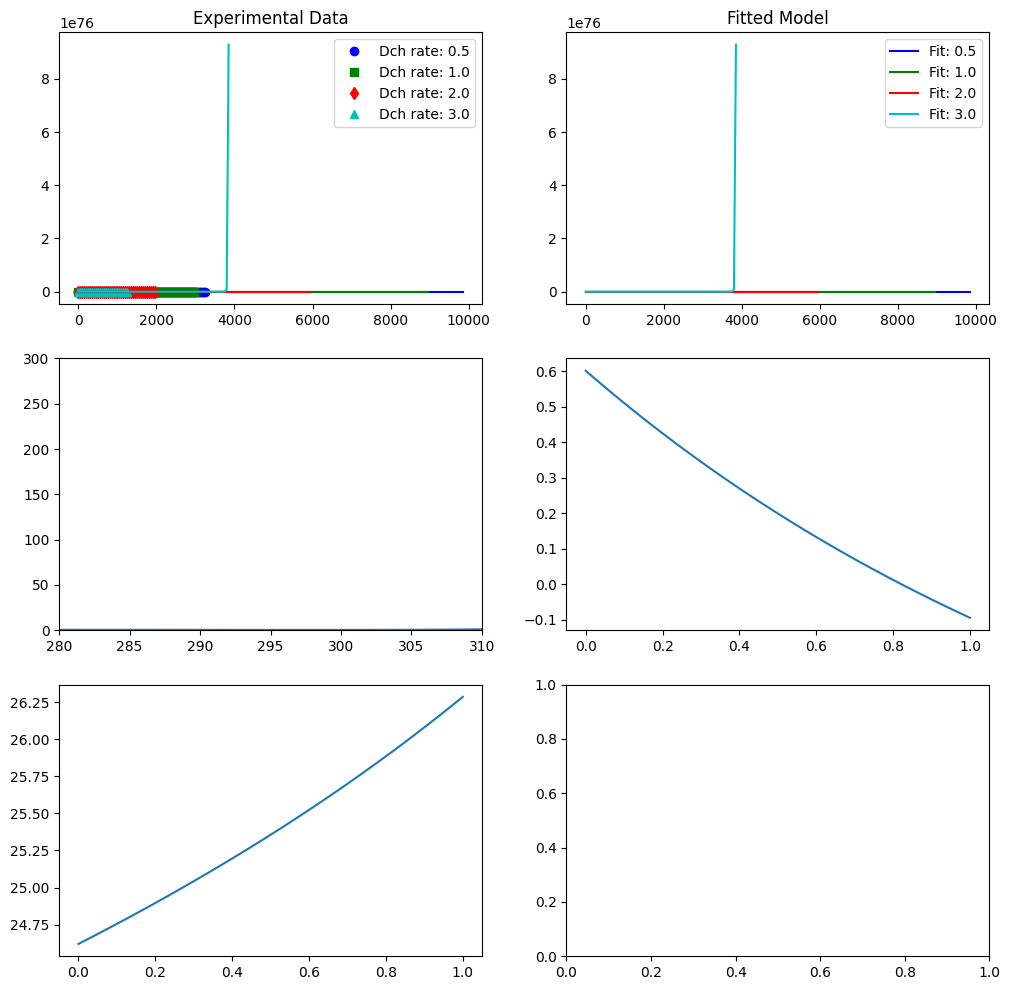

In [9]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data Loading and Generation
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])
Templist  = np.array([298, 298, 298, 298, 298, 298])
Cratelist = np.array([0.53, 0.5, 0.8, 0.8, 1.0, 1.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])



exp_clist = np.array([0.37, 0.36, 0.46, 0.39 ])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56 ])
Templist  = np.array([298, 298, 298, 298 ])
Cratelist = np.array([0.53, 0.5, 0.8, 0.8 ])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0 ])
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300 ])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride),
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition and Constants
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""
    h, DT, a = params
    # Taking absolute values in DT and a to help keep function positive
    return h + np.abs(DT) * np.power(1. - np.exp(np.abs(a) * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [ca, A, cb, Rho]"""
    ca, A, cb, Rho = params
    return ca * np.power(A, Crate) + cb * np.exp(Crate / Rho)

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [ca, A, cb, Rho]"""
    ca, A, cb, Rho = params
    return ca * np.power(A, Crate) + cb * np.exp(Crate / Rho)

def CombinedQloss(params, condition, cyc):
    """
    Combined model output.
    
    The parameter vector is assumed to be of length 34:
      - Q1 component uses params[0:12]:
            T_params = params[0:3]   -> for Q1Temp
            Ch_params = params[3:7]  -> for Q1ChCrate (used here for discharge)
            Dch_params = params[7:11] -> for Q1DchCrate (used here for discharge)
            B0 = params[11]          -> scale factor
      - Q3 component uses params[12:34]:
            Tm0_params = params[12:15]
            Chm0_params = params[15:19]
            Dhm0_params = params[19:23]
            TFcm_params = params[23:26]
            ChFcm_params = params[26:30]
            DchFcm_params = params[30:34]
    
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    
    The function returns Q1_out + Q3_out.
    """
    # Q1 component
    T_params = params[0:3]
    Ch_params = params[3:7]
    Dch_params = params[7:11]
    B0 = params[11]
    Temp, ChCrate, DchCrate = condition
    Q1_out = (B0 * Q1Temp(T_params, Temp) *
              Q1DchCrate(Ch_params, ChCrate) *
              Q1DchCrate(Dch_params, DchCrate) *
              np.exp(-_Ea / (Temp * _R)) *
              np.power(cyc, _n))
    
    # Q3 component
    Tm0_params   = params[12:15]
    Chm0_params  = params[15:19]
    Dhm0_params  = params[19:23]
    TFcm_params  = params[23:26]
    ChFcm_params = params[26:30]
    DchFcm_params= params[30:34]
    Q3_inner = ( Q1Temp(Tm0_params, Temp) +
                 Q1DchCrate(Chm0_params, ChCrate) +
                 Q1DchCrate(Dhm0_params, DchCrate) )
    Q3_factor = np.exp(Q1Temp(TFcm_params, Temp) *
                       Q1DchCrate(ChFcm_params, ChCrate) *
                       Q1DchCrate(DchFcm_params, DchCrate) * cyc) - 1
    Q3_out = np.exp(-Q3_inner) * Q3_factor
    
    return Q1_out + Q3_out

# -------------------------
# Initial Guess and Condition Data
# -------------------------
# Q1 Initial Guess (12 parameters)
T1_initial_guess = [1, 0.2, 0.07]    # for Q1Temp
C1_initial_guess = [1, 1, 1, 20]      # for Q1ChCrate (used in Q1 part)
D1_initial_guess = [1, 4, 24, 30]     # for Q1DchCrate (used in Q1 part)
B0_initial_guess = [5000.]            # scale factor
Q1_initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# Q3 Initial Guess (22 parameters)
Tm0_initial_guess  = [1, 0.3, 0.5]
Chm0_initial_guess = [2, 1, 2, 16]
Dhm0_initial_guess = [0.5, 4, 0.2, 24]
TFcm_initial_guess = [0.13, 0.5, 0.043]
ChFcm_initial_guess = [2, 1, 2, 16]
DchFcm_initial_guess = [0.5, 4, 0.2, 24]
Q3_initial_guess = (Tm0_initial_guess + Chm0_initial_guess + Dhm0_initial_guess +
                    TFcm_initial_guess + ChFcm_initial_guess + DchFcm_initial_guess)

# Combined initial guess: total length 34
initial_guess = Q1_initial_guess + Q3_initial_guess

# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Weighted Objective Function with Penalty (for IRLS)
# -------------------------
def weighted_objective(params, weights, loss_data, condition_data):
    total_loss = 0.0
    # Sum weighted squared residuals over all datasets
    for i, (data, condition) in enumerate(zip(loss_data, condition_data)):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = CombinedQloss(params, condition, cycles)
        residual = Qloss_data - model_output
        total_loss += weights[i] * np.linalg.norm(residual)**2

    # Penalty: enforce that Q1Temp, Q1ChCrate, Q1DchCrate (for all three model parts) are > 0.
    penalty = 0.0
    # For Q1 part:
    for condition in condition_data:
        Temp, ChCrate, DchCrate = condition
        f_temp   = Q1Temp(params[0:3], Temp)
        f_charge = Q1ChCrate(params[3:7], ChCrate)
        f_dch    = Q1DchCrate(params[7:11], DchCrate)
        if f_temp <= 0:
            penalty += 1e10 * (abs(f_temp) + 1.0)
        if f_charge <= 0:
            penalty += 1e10 * (abs(f_charge) + 1.0)
        if f_dch <= 0:
            penalty += 1e10 * (abs(f_dch) + 1.0)
            
    # For Q3 part:
    for condition in condition_data:
        Temp, ChCrate, DchCrate = condition
        fm0_temp   = Q1Temp(params[12:15], Temp)
        fm0_charge = Q1ChCrate(params[15:19], ChCrate)
        fm0_dch    = Q1DchCrate(params[19:23], DchCrate)
        if fm0_temp <= 0:
            penalty += 1e10 * (abs(fm0_temp) + 1.0)
        if fm0_charge <= 0:
            penalty += 1e10 * (abs(fm0_charge) + 1.0)
        if fm0_dch <= 0:
            penalty += 1e10 * (abs(fm0_dch) + 1.0)
        fFcm_temp   = Q1Temp(params[23:26], Temp)
        fFcm_charge = Q1ChCrate(params[26:30], ChCrate)
        fFcm_dch    = Q1DchCrate(params[30:34], DchCrate)
        if fFcm_temp <= 0:
            penalty += 1e10 * (abs(fFcm_temp) + 1.0)
        if fFcm_charge <= 0:
            penalty += 1e10 * (abs(fFcm_charge) + 1.0)
        if fFcm_dch <= 0:
            penalty += 1e10 * (abs(fFcm_dch) + 1.0)
    return total_loss + penalty

# -------------------------
# IRLS with Basin Hopping and Penalty
# -------------------------
max_irls_iter = 1   # Maximum number of IRLS iterations
tol = 1e-3           # Convergence tolerance
epsilon = 1e-6       # Small constant to avoid division by zero

weights = np.ones(len(loss_data))
params = np.array(initial_guess)

print("Starting IRLS with Basin Hopping (with penalty) for global optimization:")
for it in range(max_irls_iter):
    minimizer_kwargs = {'method': 'L-BFGS-B', 'tol': tol, 'args': (weights, loss_data, condition_data)}
    result = opt.basinhopping(weighted_objective, params, minimizer_kwargs=minimizer_kwargs, niter=200, disp=True)
    new_params = result.x

    # Update weights: inverse of squared residual plus epsilon for each dataset
    new_weights = []
    for data, condition in zip(loss_data, condition_data):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = CombinedQloss(new_params, condition, cycles)
        residual = Qloss_data - model_output
        res_norm2 = np.linalg.norm(residual)**2
        new_weight = 1.0 / (res_norm2 + epsilon)
        new_weights.append(new_weight)
    new_weights = np.array(new_weights)

    print(f"Iteration {it}:")
    print("  Params =", new_params)
    print("  Weights =", new_weights)

    if np.linalg.norm(new_params - params) < tol and np.linalg.norm(new_weights - weights) < tol:
        params = new_params
        weights = new_weights
        break

    params = new_params
    weights = new_weights

print("\nOptimized Parameters after IRLS with Basin Hopping and Penalty:")
print(params)

# -------------------------
# Plotting the Results
# -------------------------
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot experimental data on the upper left subplot.
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0,0].plot(x_data, y_data, linestyle='', marker=markers[k],
                 color=colors[k], label=f'Dch rate: {Drate}')
ax[0,0].legend()
ax[0,0].set_title("Experimental Data")

# Generate fitted model curves using the optimized parameters.
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + int(maxcycle*2.), _stride),
         CombinedQloss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0,0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
                 label=f'Fit: {Dratelist[k]}')
    ax[0,1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
                 label=f'Fit: {Dratelist[k]}')
ax[0,1].legend()
ax[0,1].set_title("Fitted Model")

temp = np.column_stack((tx := np.linspace(280,310,100), Q1Temp(params[0:3], tx)))
ax[1,0].plot(temp[:,0], temp[:,1], linestyle='-')
ax[1,0].set_xlim(280,310)
ax[1,0].set_ylim(0,300)

ch_crate = np.column_stack((cr := np.linspace(0,1,100), Q1ChCrate(params[3:7], cr)))
ax[1,1].plot(ch_crate[:,0], ch_crate[:,1], linestyle='-')

dch_crate = np.column_stack((cr := np.linspace(0,1,100), Q1DchCrate(params[7:11], cr)))
ax[2,0].plot(dch_crate[:,0], dch_crate[:,1], linestyle='-')

plt.show()
